In [171]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib inline
import os

# Analysis of HDF5 files

Abtastfrequenz der HDF5 Dateien: 432080/(24*60*60)s = 5 1/s ---> 1 Wert representiert 0.2 Sekunden

### Umwandlung in minütliche Auflösung

# Import von allen 3 Phasen + Allen transienten

In [172]:
Phase_1 = pd.read_hdf('HDF5/phase_1_2017-03-03.h5', usecols=['P'])
Phase_2 = pd.read_hdf('HDF5/phase_2_2017-03-03.h5', usecols=['P'])
Phase_3 = pd.read_hdf('HDF5/phase_3_2017-03-03.h5', usecols=['P'])

In [173]:
# Alle transienten aus pkl

In [174]:
transients_1_phase = pd.read_pickle("transients_1_phase.pkl")
transients_2_phase =  pd.read_pickle("transients_2_phase.pkl")
transients_3_phase =  pd.read_pickle("transients_3_phase.pkl")
#events_from_outside =  pd.read_pickle("events_from_outside.pkl")
transients_all = pd.concat([transients_1_phase,transients_2_phase,transients_3_phase])


In [175]:
# Transienten vom 03-03 ohne split

In [176]:
data = import_trasient_from_file("jsons/")
data = map_transients_to_PQ_data(data, "HDF5", 20, ['P'])
# A unique index is needed in order to assign the new features to each unique transient
data['unique_index'] = range(1, len(data) + 1)
data = data.reset_index()
data = data.set_index('unique_index')


data['charging_status']=0
data['P_mean']=0
data['P_delta'] = 0
data['P_Plugin']=0
data['P_Unplug'] = 0
data['P_Before'] = 0
for row in range(0, len(data)):
    # Getting the mean power before during and after the timestamp (-T, T)
    # Defining charging_status as 1 for avg(P)>300W else 0 and writing it to a new column
    P_mean = sum(data.iloc[row]['P']) / float(len(data.iloc[row]['P']))
    data.set_value(data.index[row],'P_mean', P_mean)
    if P_mean>300:
        data.set_value(data.index[row],'charging_status',int(1))
    else:
       data.set_value(data.index[row],'charging_status', int(0))
     # Defining if a new car is plugged in during the appearance of the transient
    P_mean_before = sum((data.iloc[row]['P'])[:10]) / float(len((data.iloc[row]['P'])[:10])) 
    
    P_mean_after = sum((data.iloc[row]['P'])[(len(data.iloc[row]['P'])-10):]) / float(len((data.iloc[row]['P'])[(len(data.iloc[row]['P'])-10):])) 
    P_delta = P_mean_after - P_mean_before
    data.set_value(data.index[row],'P_delta',P_delta)
    data.set_value(data.index[row],'P_Before',P_mean_before)
    if P_delta > 2000:
        data.set_value(data.index[row],'P_Plugin',int(1))
    else:
        data.set_value(data.index[row],'P_Plugin',int(0))
    if P_delta < -2000:
        data.set_value(data.index[row],'P_Unplug',int(1))
    else:
        data.set_value(data.index[row],'P_Unplug',int(0))
        

#resetting index to begin_timestamp_float
data = data.set_index('begin_timestamp_float')

100% (46 of 46) |#########################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (58 of 58) |#########################| Elapsed Time: 0:00:16 Time: 0:00:16


In [177]:
transients_new_import = data
print (len(transients_new_import))
print (len(transients_all))



58
492


Filtern aller transienten nach transienten vom 03_03

In [178]:
start = Phase_1.iloc[0]['timestamp']
end = Phase_1.iloc[len(Phase_1)-1]['timestamp']
print (str(start)+'       '+str(end))
print(end-start)

1488495600.15       1488581999.85
86399.699744


In [179]:
transients_03_03 = transients_new_import.loc[(transients_new_import.index >= start) & (transients_new_import.index <= end)]
transients_all_03_03 = transients_all.loc[(transients_all.index >= start) & (transients_all.index <= end)]
transients_03_03 = transients_03_03.loc[transients_03_03['P_Plugin'] == 1]
print (len(transients_03_03))
print (len(transients_all_03_03))

11
14


#### Plot Leistung volle Auflösung (5 1/s --> 432000 Datenpunkte)

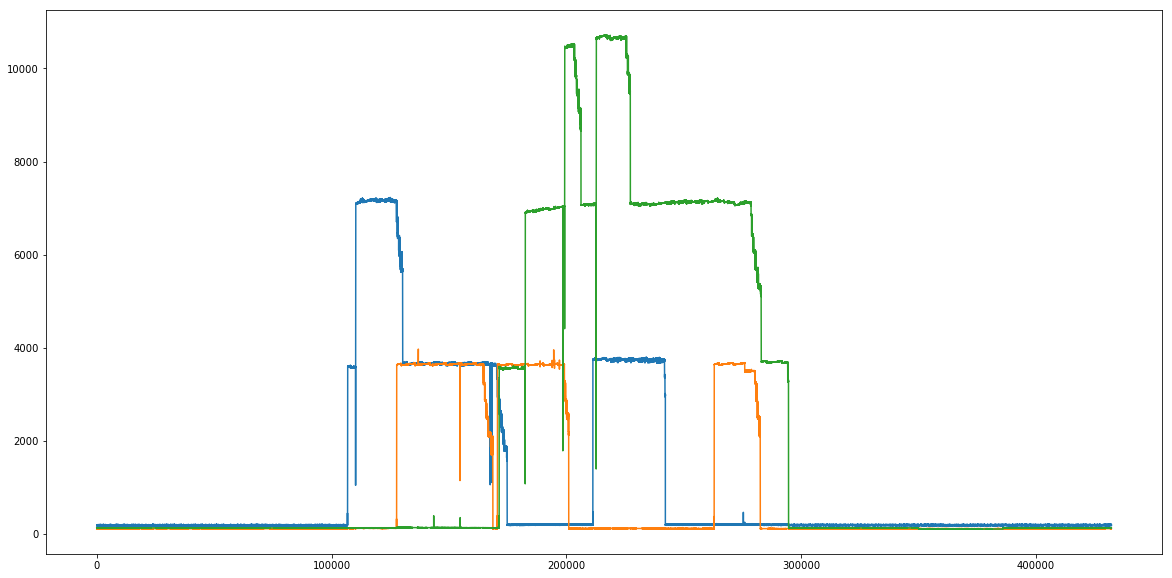

In [180]:
plt.figure(figsize=(20,10))
plt.plot(Phase_1['P'])
plt.plot(Phase_2['P'])
plt.plot(Phase_3['P'])

#### Plot in minütlicher Auflösung

In [181]:
Phase_1.index//2
Phase_2.index//2
Phase_3.index//2
Phase_1 = Phase_1.groupby(np.arange(len(Phase_1))//300).mean()
Phase_2 = Phase_2.groupby(np.arange(len(Phase_2))//300).mean()
Phase_3 = Phase_3.groupby(np.arange(len(Phase_3))//300).mean()

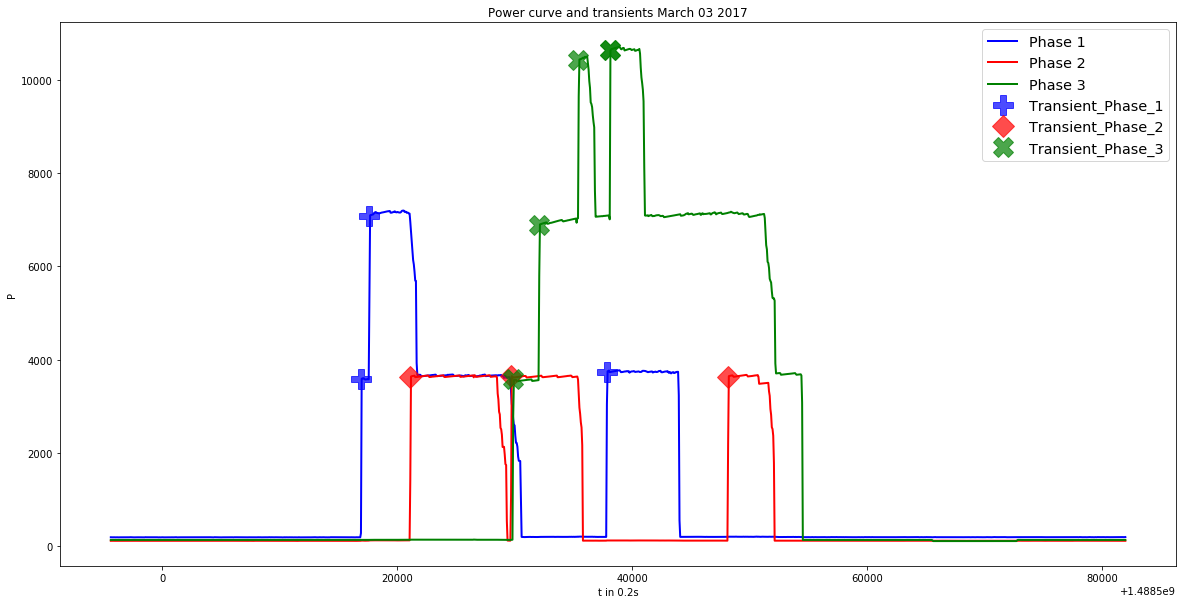

In [182]:
plt.figure(figsize=(20,10))
plt.plot(Phase_1['timestamp'],Phase_1['P'], color="blue", linewidth=2, label='Phase 1')
plt.plot(Phase_2['timestamp'],Phase_2['P'], color="red", linewidth=2, label='Phase 2')
plt.plot(Phase_3['timestamp'],Phase_3['P'], color="green", linewidth=2, label='Phase 3')
plt.plot((transients_03_03.loc[transients_03_03['phase_num'] == 1]).index,((transients_03_03.loc[transients_03_03['phase_num'] == 1])['P_delta']+(transients_03_03.loc[transients_03_03['phase_num'] == 1])['P_Before']), "P", color="blue", markersize=20,alpha=.7,label='Transient_Phase_1')
plt.plot((transients_03_03.loc[transients_03_03['phase_num'] == 2]).index,((transients_03_03.loc[transients_03_03['phase_num'] == 2])['P_delta']+(transients_03_03.loc[transients_03_03['phase_num'] == 2])['P_Before']), "D", color="red", markersize=16,alpha=.7,label='Transient_Phase_2')
plt.plot((transients_03_03.loc[transients_03_03['phase_num'] == 3]).index,((transients_03_03.loc[transients_03_03['phase_num'] == 3])['P_delta']+(transients_03_03.loc[transients_03_03['phase_num'] == 3])['P_Before']), "X", color="green", markersize=20,alpha=.7, label='Transient_Phase_3')
plt.legend(loc='upper right', frameon=True, fontsize = 'x-large')
plt.title('Power curve and transients March 03 2017')
plt.ylabel('P')
plt.xlabel('t in 0.2s')

In [183]:
transients_1_phase = transients_1_phase.loc[(transients_1_phase.index >= start) & (transients_1_phase.index <= end)]
transients_2_phase = transients_2_phase.loc[(transients_2_phase.index >= start) & (transients_2_phase.index <= end)]
transients_3_phase = transients_3_phase.loc[(transients_3_phase.index >= start) & (transients_3_phase.index <= end)]

In [184]:
print ('Eine:' + str(len(transients_1_phase)))
print ('Zwei:' + str(len(transients_2_phase)))
print ('Drei:' + str(len(transients_3_phase)))

Eine:8
Zwei:6
Drei:0


In [185]:
transients_2_phase

,begin_index,begin_timestamp_string,filtered_signal,phase_num,raw_signal_current,raw_signal_voltage,three_first_peaks,three_first_peaks_index,transient_rise_gradient,P,charging_status,P_mean,P_delta,P_Plugin,P_Unplug
1.488517e+09,2668,03-03-2017_05:55:46_156657,"[0.02547911, -0.038497164800000004, -0.0916581...",1,"[-1.708984375, -1.7852783203, -1.7242431641, -...","[0.1040188, -0.0520094, -0.2470446527, -0.3770...","[76.325, 22.823, 0.918]","[2679, 3390, 7102]",-3.458054e+06,"[187.48826599121094, 183.13340759277344, 184.0...",1,1334,3401,1,0
1.488517e+09,2668,03-03-2017_05:55:46_156657,"[0.1843011826, 0.14611922200000002, 0.13242222...",2,"[0.8239746094, 0.8392333984, 0.8392333984, 0.8...","[289.647277832, 289.8289489746, 289.8938293457...","[25.445, 20.896, 17.552]","[2680, 2692, 3390]",-1.065302e+06,"[108.477783203125, 108.63043975830078, 108.443...",0,110,4,0,0
1.488518e+09,7725,03-03-2017_06:07:18_108197,"[-1.816e-07, 0.0260045347, -0.0390071902, -0.1...",1,"[3.1585693359, 3.1890869141, 3.1890869141, 3.2...","[-0.2210399508, -0.013002350000000001, 0.28605...","[59.616, 13.444, 32.675]","[7736, 7805, 8459]",-2.656616e+06,"[3576.65966796875, 3574.044189453125, 3582.587...",1,4725,3507,1,0
1.488518e+09,7725,03-03-2017_06:07:18_108197,"[0.1556879355, 0.090807573, 0.1556879456000000...",2,"[-1.0986328125, -1.0681152344, -1.0375976562, ...","[-290.1403503418, -290.1273803711, -290.257141...","[26.159, 14.247, 12.483]","[7735, 7750, 8457]",-1.317699e+06,"[112.70105743408203, 112.44549560546875, 112.9...",0,114,4,0,0
1.488532e+09,4307,03-03-2017_10:08:03_134070,"[0.2984186058, 0.2206117263, 0.285437947100000...",2,"[19.9127197266, 19.8669433594, 19.8974609375, ...","[290.9318847656, 291.0097351074, 291.100585937...","[24.083, 6.267, 13.547]","[4315, 4398, 5167]",1.519807e+06,"[3646.545166015625, 3647.015380859375, 3645.12...",1,3647,0,0,0
1.488532e+09,4307,03-03-2017_10:08:03_134070,"[1.3238900000000001e-05, -0.1342614168, 0.0134...",3,"[-14.7399902344, -14.6789550781, -14.678955078...","[-294.0728149414, -293.8715209961, -293.790985...","[70.485, 22.211, 37.873]","[4316, 4343, 5168]",3.873347e+06,"[3556.302734375, 3555.559814453125, 3557.01806...",1,4591,3338,1,0


In [186]:
transients_03_03

,begin_index,begin_timestamp_string,filtered_signal,phase_num,raw_signal_current,raw_signal_voltage,three_first_peaks,three_first_peaks_index,transient_rise_gradient,P,charging_status,P_mean,P_delta,P_Plugin,P_Unplug,P_Before
begin_timestamp_float,,,,,,,,,,,,,,,,
1.488517e+09,2668,03-03-2017_05:55:46_156657,"[0.02547911, -0.038497164800000004, -0.0916581...",1,"[-1.708984375, -1.7852783203, -1.7242431641, -...","[0.1040188, -0.0520094, -0.2470446527, -0.3770...","[76.325, 22.823, 0.918]","[2679, 3390, 7102]",-3.458054e+06,"[187.48826599121094, 183.13340759277344, 184.0...",1,1334,3401,1,0,186
1.488518e+09,7725,03-03-2017_06:07:18_108197,"[-1.816e-07, 0.0260045347, -0.0390071902, -0.1...",1,"[3.1585693359, 3.1890869141, 3.1890869141, 3.2...","[-0.2210399508, -0.013002350000000001, 0.28605...","[59.616, 13.444, 32.675]","[7736, 7805, 8459]",-2.656616e+06,"[3576.65966796875, 3574.044189453125, 3582.587...",1,4725,3507,1,0,3576
1.488521e+09,6037,03-03-2017_07:05:24_794743,"[-0.5868188739, -0.39288064840000003, -0.50904...",2,"[-1.1138916016, -1.0681152344, -1.0986328125, ...","[-291.3211669922, -291.5936584473, -291.554718...","[98.945, 29.449, 52.133]","[6046, 6069, 6775]",5.497620e+06,"[118.39541625976562, 118.04408264160156, 117.7...",1,1242,3509,1,0,118
1.488530e+09,5440,03-03-2017_09:28:29_189955,"[0.0517394448, 0.1555147413, 0.0646603997, -0....",2,"[0.7934570312, 0.8087158203, 0.7476806641, 0.7...","[292.1646118164, 292.2035217285, 292.255432128...","[68.290, 17.462, 49.732]","[5454, 5487, 5977]",-2.420049e+06,"[112.1768798828125, 112.56014251708984, 112.65...",1,1308,3527,1,0,112
1.488530e+09,4372,03-03-2017_09:31:00_151826,"[0.2012155725, 0.14757921170000002, 0.18791316...",3,"[-0.9002685547, -0.8697509766, -0.9460449219, ...","[294.2741394043, 294.1667785645, 293.965454101...","[80.752, 25.016, 1.825]","[4383, 5048, 9820]",-3.661995e+06,"[130.43789672851562, 130.04774475097656, 130.1...",1,1333,3451,1,0,130
1.488532e+09,4307,03-03-2017_10:08:03_134070,"[1.3238900000000001e-05, -0.1342614168, 0.0134...",3,"[-14.7399902344, -14.6789550781, -14.678955078...","[-294.0728149414, -293.8715209961, -293.790985...","[70.485, 22.211, 37.873]","[4316, 4343, 5168]",3.873347e+06,"[3556.302734375, 3555.559814453125, 3557.01806...",1,4591,3338,1,0,3556
1.488535e+09,8452,03-03-2017_11:03:57_429314,"[-0.48833025360000004, -0.4883293557, -0.51506...",3,"[30.2581787109, 30.2124023438, 30.1361083984, ...","[295.0659484863, 294.9317626953, 294.810974121...","[59.087, 23.230, 21.311]","[8460, 8535, 9025]",3.656048e+06,"[7038.32958984375, 7039.45263671875, 7036.7578...",1,8143,3402,1,0,7039
1.488538e+09,7817,03-03-2017_11:43:54_882361,"[-0.1820760878, -0.0259758692, -0.0517178737, ...",1,"[-2.0294189453, -2.0751953125, -2.0599365234, ...","[0.32505875830000003, 0.0780140981, -0.1950352...","[81.729, 21.056, 5.179]","[7827, 8533, 9314]",4.073612e+06,"[189.49171447753906, 191.56637573242188, 192.8...",1,1289,3543,1,0,191
1.488538e+09,9666,03-03-2017_11:48:44_893795,"[0.16080156110000002, 0.1740808788, 0.13369678...",3,"[-31.0363769531, -31.0363769531, -30.975341796...","[-294.9049072266, -294.7841186523, -294.623077...","[37.771, 24.333, 4.569]","[9678, 9760, 9843]",-1.565918e+06,"[7101.31689453125, 7097.36767578125, 7097.2324...",1,8200,3552,1,0,7098
